## 知识蒸馏-ctt teacher->trans student 最终版

In [1]:
import copy
import math
import torch
import pickle
import numpy as np
import pandas as pd
import geatpy as ea
from tqdm import tqdm
from torch import nn
from torch import optim
from fill.hot_filling import hot_fill
from fill.neighbour_filling import neighbour_fill
from filter.w_mean_filter import *
from filter.rssi_guass_filter import filter_guass
from filter.kalman_filter import filter_kalman
import torch.nn.functional as F
import matplotlib.pyplot as plt
import utils.calculate_param as cp
from dataset import data_read
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from multiprocessing.dummy import Pool as ThreadPool
from sklearn.metrics import mean_absolute_error, explained_variance_score, r2_score, mean_squared_error

/Users/frank/Desktop/jupyter/RFID_TRANS/filter/


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

### 硬件设备准备

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

### 加载数据集 近邻填充+高斯滤波

In [3]:
X_train_0, y_train_0 = data_read.load_data('train')
X_test_0, y_test_0 = data_read.load_data('test')

In [4]:
X_train_neighbour = [neighbour_fill(xi) for xi in X_train_0]
X_test_neighbour = [neighbour_fill(xi) for xi in X_test_0]
X_train_guass = [filter_guass(xi) for xi in X_train_neighbour]
X_test_guass = [filter_guass(xi) for xi in X_test_neighbour]
X_train_guass = np.array(X_train_guass)
X_test_guass = np.array(X_test_guass)

X_train_guass.shape

(2000, 50)

In [5]:
X_train = torch.from_numpy(X_train_guass).float().to(device) # [len * feature]
y_train = torch.from_numpy(y_train_0).float().to(device)
X_test = torch.from_numpy(X_test_guass).float().to(device) # [len * feature]
y_test = torch.from_numpy(y_test_0).float().to(device)

X_train.shape


torch.Size([2000, 50])

In [6]:
train_data_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=100, shuffle=False)
test_data_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=100, shuffle=False)

### 定义教师模型-CTT

In [7]:
# CNN
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=3, kernel_size=7),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=7),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.out=nn.Linear(960, 50)

    def forward(self, x):
        x= self.conv1(x)
        # print(x.shape)
        x= self.conv2(x)
        # print(x.shape)
        x= x.view(-1, x.size(0) * x.size(1) * x.size(2))
        # print(x.shape)
        out = self.out(x)
        return out


# 位置编码类
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        out = x + self.pe[:x.size(0), :]
        return out


# 教师模型类
class TeacherTransformer(nn.Module):
    def __init__(self):
        super(TeacherTransformer, self).__init__()
        self.cnn = CNN()
        self.d_model = 128  # 词向量维度
        self.embedding_enc = nn.Linear(50, self.d_model)
        self.embedding_dec = nn.Linear(2, self.d_model)
        self.pos_encoding = PositionalEncoding(self.d_model)
        self.Transformer_layer = nn.Transformer(d_model=128, num_encoder_layers=3, num_decoder_layers=3, batch_first=True)
        self.FC_layer = nn.Linear(128, 2)

    def forward(self, src, tgt):
        # rssi进行cnn特征提取
        src = src.unsqueeze(0)
        src = self.cnn(src)
        # print(src.shape)
        # 使用线性层代替embedding
        src = self.embedding_enc(src).unsqueeze(0)
        tgt = self.embedding_dec(tgt).unsqueeze(0)
        src = self.pos_encoding(src)
        out = self.Transformer_layer(src, tgt)
        out = self.FC_layer(out)
        return out


### 教师模型设置

In [8]:
model = TeacherTransformer().to(device)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.99)

### 教师模型信息

In [9]:
# 输出教师模型的参数信息-380w参数
cp.get_summary(model, input_size=None)

torchinfo信息如下：
Layer (type:depth-idx)                                                 Param #
TeacherTransformer                                                     --
├─CNN: 1-1                                                             --
│    └─Sequential: 2-1                                                 --
│    │    └─Conv2d: 3-1                                                150
│    │    └─ReLU: 3-2                                                  --
│    │    └─MaxPool2d: 3-3                                             --
│    └─Sequential: 2-2                                                 --
│    │    └─Conv2d: 3-4                                                888
│    │    └─ReLU: 3-5                                                  --
│    │    └─MaxPool2d: 3-6                                             --
│    └─Linear: 2-3                                                     48,050
├─Linear: 1-2                                                          6,528
├─Linear:

### 教师模型训练

In [10]:
%%time

best_loss = 100000
best_epoch = 0
for epoch in range(150):
    epoch_loss = 0
    for X, y in train_data_loader:  # enc_inputs : [len * feature]->[2000 * 50]
        # print(X.shape)  # [100 * 50]
        # print(y.shape)  # [100 * 50]
        outputs = model(X, y)
        outputs = outputs.squeeze()  # [100 * 2]
        # print(outputs.shape)
        loss = criterion(outputs, y)
        loss_num = loss.item()
        epoch_loss += loss_num
        optimizer.zero_grad()
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

    if epoch_loss < best_loss:
        best_loss = epoch_loss
        best_epoch = epoch
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(best_model_wts, './result/ctt_weight.pth')

    print('Epoch:', '%04d' % (epoch + 1), 'loss =', '{:.6f}'.format(epoch_loss))

# 打印最佳的结果
print('best_loss::|',best_loss,'---best_epoch::|',best_epoch)


Epoch: 0001 loss = 48.209963
Epoch: 0002 loss = 32.398098
Epoch: 0003 loss = 56.208129
Epoch: 0004 loss = 44.791168
Epoch: 0005 loss = 30.543414
Epoch: 0006 loss = 20.042283
Epoch: 0007 loss = 19.167069
Epoch: 0008 loss = 15.489157
Epoch: 0009 loss = 14.397269
Epoch: 0010 loss = 14.471877
Epoch: 0011 loss = 13.984460
Epoch: 0012 loss = 13.399434
Epoch: 0013 loss = 9.966894
Epoch: 0014 loss = 8.511494
Epoch: 0015 loss = 7.465411
Epoch: 0016 loss = 5.833348
Epoch: 0017 loss = 4.991610
Epoch: 0018 loss = 4.091716
Epoch: 0019 loss = 3.264026
Epoch: 0020 loss = 3.147040
Epoch: 0021 loss = 2.568625
Epoch: 0022 loss = 2.691803
Epoch: 0023 loss = 2.313695
Epoch: 0024 loss = 2.286685
Epoch: 0025 loss = 1.923788
Epoch: 0026 loss = 1.723067
Epoch: 0027 loss = 1.705054
Epoch: 0028 loss = 1.579330
Epoch: 0029 loss = 1.393907
Epoch: 0030 loss = 1.449995
Epoch: 0031 loss = 1.183111
Epoch: 0032 loss = 1.247393
Epoch: 0033 loss = 1.231591
Epoch: 0034 loss = 1.074970
Epoch: 0035 loss = 1.102134
Epoch: 0

### 教师模型评估

In [10]:
model = TeacherTransformer().to(device)
# 暂存教师模型为teacher_model
teacher_model = model
model.load_state_dict(torch.load('./result/ctt_weight.pth'))
model.eval()

pxy_all = []
y_all = []
for X, y in test_data_loader:
    pxy = model(X, y)
    pxy = pxy.cpu().detach().numpy().squeeze(0)
    y = y.cpu().detach().numpy()
    pxy_all.append(pxy)
    y_all.append(y)

# 计算指标
pxy_all = np.array(pxy_all).reshape(-1, 2)
y_all = np.array(y_all).reshape(-1, 2)
mae = mean_absolute_error(y_all, pxy_all)
mse = mean_squared_error(y_all, pxy_all)
rmse = mse ** 0.5
evs = explained_variance_score(y_all, pxy_all)
r2 = r2_score(y_all, pxy_all)

mmax = 0
mmin = 10000
for i in range(len(pxy_all)):
    mmax = max(mean_absolute_error(y_all[i], pxy_all[i]), mmax)
    mmin = min(mean_absolute_error(y_all[i], pxy_all[i]), mmin)

print({'mae': mae, 'mse': mse, 'rmse': rmse, 'evs': evs, 'r2': r2, 'mmax': mmax, 'mmin': mmin})

y_teacher = y_all[:20]
pxy = pxy_all[:20]
coor1 = pd.DataFrame(y_teacher)
coor1.columns = ['X', 'y']

coor2 = pd.DataFrame(pxy)
coor2.columns = ['PX', 'Py']

coor = pd.concat([coor1, coor2], axis=1)
coor.to_csv('./result/coordinate_all_ctt.csv')
print(coor)

{'mae': 0.083563276, 'mse': 0.009755993, 'rmse': 0.09877243168988666, 'evs': 0.998113363981247, 'r2': 0.9952863212685581, 'mmax': 0.23729467, 'mmin': 0.017131537}
       X     y        PX        Py
0   0.21  3.47  0.245147  3.529120
1   1.13  1.96  1.196976  2.037458
2   3.38  2.58  3.509076  2.693891
3   4.07  2.72  4.230471  2.845829
4   1.58  2.47  1.647689  2.543962
5   3.43  1.61  3.568917  1.697960
6   1.22  0.74  1.316422  0.784526
7   2.33  1.97  2.433043  2.037741
8   0.33  3.56  0.355676  3.628693
9   3.53  4.28  3.655198  4.490645
10  4.42  3.69  4.636249  3.866905
11  3.67  0.34  3.831290  0.339497
12  2.57  0.37  2.694048  0.397630
13  3.14  3.22  3.244254  3.332000
14  4.76  3.34  4.918339  3.465530
15  1.70  3.71  1.770001  3.785635
16  3.50  1.20  3.626587  1.278121
17  0.68  4.65  0.639596  4.752783
18  1.09  4.59  1.075465  4.723710
19  0.25  3.70  0.270644  3.772177


### 教师模型定位效果可视化

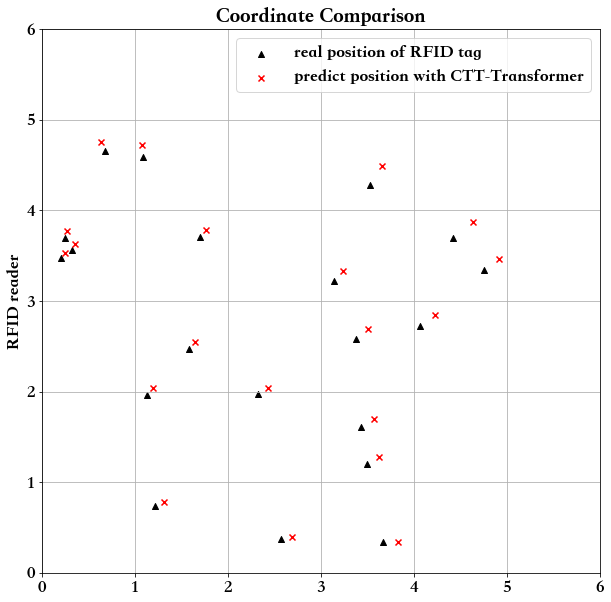

In [11]:
plt.figure(figsize=[10, 10])
plt.xlim((0, 6))
plt.ylim((0, 6))
plt.ylabel('RFID reader')
plt.title('Coordinate Comparison')
# 画图-标准坐标
plt.scatter(y_teacher[:, 0], y_teacher[:, 1], c='black', marker='^', label='real position of RFID tag')

# 画图-预测EA坐标
plt.scatter(pxy[:, 0], pxy[:, 1], c='red', marker='x', label = 'predict position with CTT-Transformer')

plt.legend()
plt.grid('True')
plt.savefig('./result/compare_coordinate_ctt.jpg', dpi=750, bbox_inches = 'tight')

### 定义学生模型-Trans模型

In [12]:
class StudentTransformer(nn.Module):
    def __init__(self):
        super(StudentTransformer, self).__init__()
        self.d_model = 3  # 词向量维度
        self.embedding_enc = nn.Linear(50, self.d_model)
        self.embedding_dec = nn.Linear(2, self.d_model)
        self.Transformer_layer = nn.Transformer(nhead=1, d_model=self.d_model, num_encoder_layers=1, num_decoder_layers=1, batch_first=True)
        self.FC_layer = nn.Linear(self.d_model, 2)

    def forward(self, src, tgt):
        # 使用线性层代替embedding
        src = self.embedding_enc(src).unsqueeze(0)
        tgt = self.embedding_dec(tgt).unsqueeze(0)
        out = self.Transformer_layer(src, tgt)
        out = self.FC_layer(out)
        return out

### 学生模型设置

In [13]:
# 从头先训练一下学生模型
model = StudentTransformer().to(device)
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

### 学生模型信息

In [14]:
# 输出学生模型的参数信息-7w参数
cp.get_summary(model, input_size=None)

torchinfo信息如下：
Layer (type:depth-idx)                                                 Param #
StudentTransformer                                                     --
├─Linear: 1-1                                                          153
├─Linear: 1-2                                                          9
├─Transformer: 1-3                                                     --
│    └─TransformerEncoder: 2-1                                         --
│    │    └─ModuleList: 3-1                                            14,399
│    │    └─LayerNorm: 3-2                                             6
│    └─TransformerDecoder: 2-2                                         --
│    │    └─ModuleList: 3-3                                            14,453
│    │    └─LayerNorm: 3-4                                             6
├─Linear: 1-4                                                          8
Total params: 29,034
Trainable params: 29,034
Non-trainable params: 0


### 学生模型训练

In [36]:
%%time
best_loss = 100000
best_epoch = 0
for epoch in range(100):
    epoch_loss = 0
    for X, y in train_data_loader:  # enc_inputs : [len * feature]->[2000 * 50]
        outputs = model(X, y)
        outputs = outputs.squeeze()  # [100 * 2]
        loss = criterion(outputs, y)
        loss_num = loss.item()
        epoch_loss += loss_num
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

    if epoch_loss < best_loss:
        best_loss = epoch_loss
        best_epoch = epoch
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(best_model_wts, './result/student_weight.pth')

    print('Epoch:', '%04d' % (epoch + 1), 'loss =', '{:.6f}'.format(epoch_loss))

# 打印最佳的结果
print('best_loss::|', best_loss, '---best_epoch::|', best_epoch)


Epoch: 0001 loss = 101.212175
Epoch: 0002 loss = 86.490384
Epoch: 0003 loss = 77.981261
Epoch: 0004 loss = 71.346139
Epoch: 0005 loss = 63.942382
Epoch: 0006 loss = 57.855831
Epoch: 0007 loss = 51.626078
Epoch: 0008 loss = 46.379466
Epoch: 0009 loss = 41.276074
Epoch: 0010 loss = 36.352409
Epoch: 0011 loss = 31.852759
Epoch: 0012 loss = 27.952296
Epoch: 0013 loss = 25.311315
Epoch: 0014 loss = 22.504377
Epoch: 0015 loss = 20.623116
Epoch: 0016 loss = 19.435793
Epoch: 0017 loss = 18.418738
Epoch: 0018 loss = 17.453343
Epoch: 0019 loss = 16.214275
Epoch: 0020 loss = 15.703834
Epoch: 0021 loss = 15.428774
Epoch: 0022 loss = 15.028601
Epoch: 0023 loss = 14.124627
Epoch: 0024 loss = 13.556917
Epoch: 0025 loss = 13.915006
Epoch: 0026 loss = 13.622550
Epoch: 0027 loss = 13.076172
Epoch: 0028 loss = 13.211884
Epoch: 0029 loss = 12.922375
Epoch: 0030 loss = 12.635593
Epoch: 0031 loss = 12.514713
Epoch: 0032 loss = 12.759451
Epoch: 0033 loss = 12.771022
Epoch: 0034 loss = 12.168550
Epoch: 0035 l

### 学生模型评估

In [15]:
model = StudentTransformer().to(device)
student_model = model
model.load_state_dict(torch.load('./result/student_weight.pth'))
model.eval()

pxy_all = []
y_all = []
for X, y in test_data_loader:
    pxy = model(X, y)
    pxy = pxy.cpu().detach().numpy().squeeze(0)
    y = y.cpu().detach().numpy()
    pxy_all.append(pxy)
    y_all.append(y)

# 计算指标
pxy_all = np.array(pxy_all).reshape(-1, 2)
y_all = np.array(y_all).reshape(-1, 2)
mae = mean_absolute_error(y_all, pxy_all)
mse = mean_squared_error(y_all, pxy_all)
rmse = mse ** 0.5
evs = explained_variance_score(y_all, pxy_all)
r2 = r2_score(y_all, pxy_all)

mmax = 0
mmin = 10000
for i in range(len(pxy_all)):
    mmax = max(mean_absolute_error(y_all[i], pxy_all[i]), mmax)
    mmin = min(mean_absolute_error(y_all[i], pxy_all[i]), mmin)

print({'mae': mae, 'mse': mse, 'rmse': rmse, 'evs': evs, 'r2': r2, 'mmax': mmax, 'mmin': mmin})

y_student = y_all[:20]
pxy = pxy_all[:20]
coor1 = pd.DataFrame(y_student)
coor1.columns = ['X', 'y']

coor2 = pd.DataFrame(pxy)
coor2.columns = ['PX', 'Py']

coor = pd.concat([coor1, coor2], axis=1)
coor.to_csv('./result/coordinate_all_student.csv')
print(coor)


{'mae': 0.50351256, 'mse': 0.38939306, 'rmse': 0.6240136708434038, 'evs': 0.8137162327766418, 'r2': 0.8115150827694991, 'mmax': 1.3295649, 'mmin': 0.052773297}
       X     y        PX        Py
0   0.21  3.47  0.985192  2.971538
1   1.13  1.96  0.335635  2.430167
2   3.38  2.58  4.358854  3.121175
3   4.07  2.72  4.273503  2.658647
4   1.58  2.47  1.001470  2.983622
5   3.43  1.61  3.759949  1.652072
6   1.22  0.74  2.026583 -0.079644
7   2.33  1.97  1.354956  3.229698
8   0.33  3.56  1.059654  3.026262
9   3.53  4.28  3.705998  3.982297
10  4.42  3.69  4.353628  3.294033
11  3.67  0.34  3.203012  0.958580
12  2.57  0.37  2.782704  0.537177
13  3.14  3.22  3.787905  3.963034
14  4.76  3.34  4.308675  2.784966
15  1.70  3.71  1.864414  3.531085
16  3.50  1.20  3.504825  1.309543
17  0.68  4.65  1.554432  3.355132
18  1.09  4.59  1.727665  3.456317
19  0.25  3.70  1.087991  3.046719


### 学生模型定位效果可视化

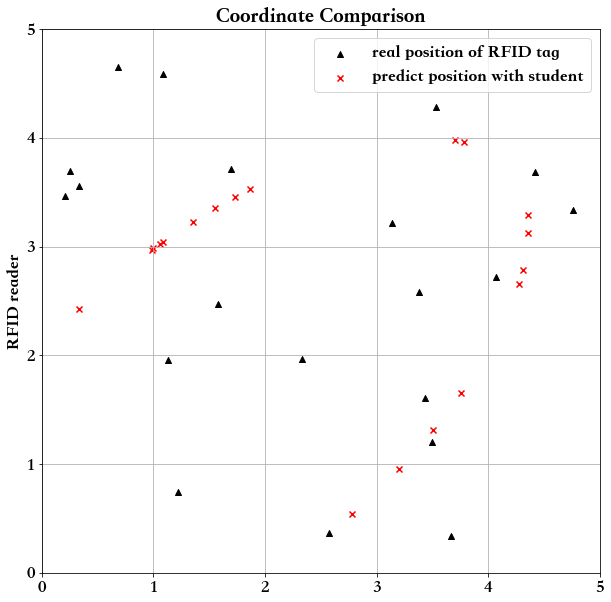

In [16]:
plt.figure(figsize=[10, 10])
plt.xlim((0, 5))
plt.ylim((0, 5))
plt.ylabel('RFID reader')
plt.title('Coordinate Comparison')
# 画图-标准坐标
plt.scatter(y_student[:, 0], y_student[:, 1], c='black', marker='^', label='real position of RFID tag')

# 画图-预测EA坐标
plt.scatter(pxy[:, 0], pxy[:, 1], c='red', marker='x', label = 'predict position with student')

plt.legend()
plt.grid('True')
plt.savefig('./result/compare_coordinate_student.jpg', dpi=750, bbox_inches = 'tight')

### 知识蒸馏准备与设置

In [17]:
# 准备预训练好的教师模型
teacher_model.eval()

# 准备新的学生模型
model = StudentTransformer().to(device)
beta = 0.9
m = 0.5

# 回归分析的损失函数设置 = 平滑l1loss + beta * 范围loss
# loss = smoothl1loss + beta * boundloss
loss1 = nn.SmoothL1Loss()
loss2 = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

### 知识蒸馏训练

In [45]:
%%time
best_loss = 100000
best_epoch = 0
for epoch in range(150):
    epoch_loss = 0
    for X, y in train_data_loader:
        X, y = X.to(device), y.to(device)
        # 教师模型预测
        with torch.no_grad():
            teacher_outputs = teacher_model(X, y)
            teacher_outputs = teacher_outputs.squeeze(0)
        # 学生模型预测
        student_outputs = model(X, y)
        student_outputs = student_outputs.squeeze(0)
        # 回归损失
        ls = loss2(student_outputs, y)
        lt = loss2(teacher_outputs, y)
        loss = loss1(student_outputs, y)  # smooth loss
        if ls.item() + m > lt.item():  # bound loss
            loss += beta * ls
        # 反向传播,优化权重
        optimizer.zero_grad()
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()

    if epoch_loss < best_loss:
        best_loss = epoch_loss
        best_epoch = epoch
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(best_model_wts, './result/distillation_weight.pth')

    print('Epoch:', '%04d' % (epoch + 1), 'loss =', '{:.6f}'.format(epoch_loss))

# 打印最佳的结果
print('best_loss::|',best_loss,'---best_epoch::|',best_epoch)


Epoch: 0001 loss = 169.779580
Epoch: 0002 loss = 154.254117
Epoch: 0003 loss = 143.579473
Epoch: 0004 loss = 135.142330
Epoch: 0005 loss = 127.426573
Epoch: 0006 loss = 119.634819
Epoch: 0007 loss = 112.219255
Epoch: 0008 loss = 105.035835
Epoch: 0009 loss = 98.019361
Epoch: 0010 loss = 90.996622
Epoch: 0011 loss = 84.418932
Epoch: 0012 loss = 77.730591
Epoch: 0013 loss = 71.514447
Epoch: 0014 loss = 65.791993
Epoch: 0015 loss = 60.120244
Epoch: 0016 loss = 54.932724
Epoch: 0017 loss = 50.205128
Epoch: 0018 loss = 46.008524
Epoch: 0019 loss = 42.155789
Epoch: 0020 loss = 38.754170
Epoch: 0021 loss = 35.692078
Epoch: 0022 loss = 33.293505
Epoch: 0023 loss = 30.940177
Epoch: 0024 loss = 29.057094
Epoch: 0025 loss = 27.381386
Epoch: 0026 loss = 25.847626
Epoch: 0027 loss = 24.738577
Epoch: 0028 loss = 23.327516
Epoch: 0029 loss = 22.643391
Epoch: 0030 loss = 21.805482
Epoch: 0031 loss = 21.310588
Epoch: 0032 loss = 20.330510
Epoch: 0033 loss = 19.596609
Epoch: 0034 loss = 19.086791
Epoch:

### 蒸馏模型评估

In [18]:
model = StudentTransformer().to(device)
model.load_state_dict(torch.load('./result/distillation_weight.pth'))
model.eval()

pxy_all = []
y_all = []
for X, y in test_data_loader:
    pxy = model(X, y)
    pxy = pxy.cpu().detach().numpy().squeeze(0)
    y = y.cpu().detach().numpy()
    pxy_all.append(pxy)
    y_all.append(y)

# 计算指标
pxy_all = np.array(pxy_all).reshape(-1, 2)
y_all = np.array(y_all).reshape(-1, 2)
mae = mean_absolute_error(y_all, pxy_all)
mse = mean_squared_error(y_all, pxy_all)
rmse = mse ** 0.5
evs = explained_variance_score(y_all, pxy_all)
r2 = r2_score(y_all, pxy_all)

mmax = 0
mmin = 10000
for i in range(len(pxy_all)):
    mmax = max(mean_absolute_error(y_all[i], pxy_all[i]), mmax)
    mmin = min(mean_absolute_error(y_all[i], pxy_all[i]), mmin)

print({'mae': mae, 'mse': mse, 'rmse': rmse, 'evs': evs, 'r2': r2, 'mmax': mmax, 'mmin': mmin})

y_distill = y_all[:20]
pxy = pxy_all[:20]
coor1 = pd.DataFrame(y_distill)
coor1.columns = ['X', 'y']

coor2 = pd.DataFrame(pxy)
coor2.columns = ['PX', 'Py']

coor = pd.concat([coor1, coor2], axis=1)
coor.to_csv('./result/coordinate_all_distill.csv')
print(coor)

{'mae': 0.4528178, 'mse': 0.35159886, 'rmse': 0.5929577209492368, 'evs': 0.8294727206230164, 'r2': 0.8293233253526728, 'mmax': 1.7410696, 'mmin': 0.02195704}
       X     y        PX        Py
0   0.21  3.47  0.597182  3.453387
1   1.13  1.96 -0.761869  0.369730
2   3.38  2.58  4.447841  2.760071
3   4.07  2.72  4.439410  2.712991
4   1.58  2.47  0.593868  3.452060
5   3.43  1.61  3.706064  1.642049
6   1.22  0.74  1.340622  0.464520
7   2.33  1.97  3.511646  1.483641
8   0.33  3.56  0.651546  3.474865
9   3.53  4.28  3.228709  3.871649
10  4.42  3.69  4.199565  3.481768
11  3.67  0.34  3.117561  1.212142
12  2.57  0.37  2.414230  0.839605
13  3.14  3.22  3.786991  3.732840
14  4.76  3.34  4.431844  3.106345
15  1.70  3.71  1.628835  3.771541
16  3.50  1.20  3.485194  1.463527
17  0.68  4.65  1.136723  3.642862
18  1.09  4.59  1.327056  3.697543
19  0.25  3.70  0.674858  3.483907


### 蒸馏模型定位效果可视化

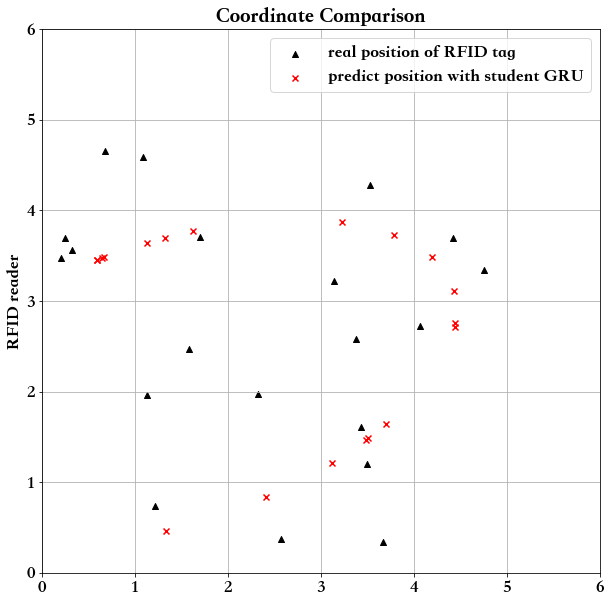

In [19]:
plt.figure(figsize=[10, 10])
plt.xlim((0, 6))
plt.ylim((0, 6))
plt.ylabel('RFID reader')
plt.title('Coordinate Comparison')
# 画图-标准坐标
plt.scatter(y_distill[:, 0], y_distill[:, 1], c='black', marker='^', label='real position of RFID tag')

# 画图-预测EA坐标
plt.scatter(pxy[:, 0], pxy[:, 1], c='red', marker='x', label = 'predict position with student GRU')

plt.legend()
plt.grid('True')
plt.savefig('./result/compare_coordinate_distill.jpg', dpi=750, bbox_inches = 'tight')

### 定义问题类

In [20]:
class MOEA(ea.Problem):
    def __init__(self, train_data_loader, test_data_loader):
        name = 'MOEA'
        M = 1 # 初始化M（目标维数）
        maxormins = [1] # 初始化maxormins（目标最小最大化标记列表，1：最小化该目标；-1：最大化该目标）
        Dim = 2 # 初始化Dim（决策变量维数）先调节beta和m两个参数
        varTypes = np.array([0] * Dim) # 初始化varTypes 0-连续
        lb = [0.5, 0.5] # 决策变量下界
        ub = [1, 0.9] # 决策变量上界
        lbin = [1] * Dim # 决策变量下边界（0表示不包含该变量的下边界，1表示包含）
        ubin = [1] * Dim # 决策变量上边界（0表示不包含该变量的上边界，1表示包含）
        # 调用父类构造方法完成实例化
        ea.Problem.__init__(self, name, M, maxormins, Dim, varTypes, lb, ub, lbin, ubin)
        # 数据设置
        self.train_data_loader = train_data_loader
        self.test_data_loader = test_data_loader


    # 目标函数，采用多线程加速计算
    def aimFunc(self, pop):
        Vars = pop.Phen # 得到决策变量矩阵
        # print(Vars)
        pop.ObjV = np.zeros((pop.sizes, 1)) # 初始化种群个体目标函数值列向量
        def subAimFunc(i):
            beta, m = float(Vars[i, 0]), float(Vars[i, 1])
            # print('parameters: ', beta, m)
            final_loss = 0
            for epoch in range(150):
                for X, y in train_data_loader:
                    X, y = X.to(device), y.to(device)
                    # 教师模型预测
                    with torch.no_grad():
                        teacher_outputs = teacher_model(X, y)
                        teacher_outputs = teacher_outputs.squeeze(0)
                    # 学生模型预测
                    student_outputs = model(X, y)
                    student_outputs = student_outputs.squeeze(0)
                    # 回归损失
                    ls = loss2(student_outputs, y)
                    lt = loss2(teacher_outputs, y)
                    loss = loss1(student_outputs, y)  # smooth loss
                    if ls.item() + m > lt.item():  # bound loss
                        loss += beta * ls
                    # 反向传播,优化权重
                    optimizer.zero_grad()
                    final_loss += loss.item()
                    loss.backward()
                    optimizer.step()

            pop.ObjV[i] = final_loss # 最小化最终的损失作为目标函数
            print('final loss: ', final_loss)
        pool = ThreadPool(processes=2) # 设置池的大小
        pool.map(subAimFunc, list(range(pop.sizes))) # 散列种群每个个体进行加速计算


    # 代入优化后的参数先训练再对测试集进行检验，计算指标
    def test(self, beta, m):
        for epoch in range(150):
            for X, y in train_data_loader:
                X, y = X.to(device), y.to(device)
                # 教师模型预测
                with torch.no_grad():
                    teacher_outputs = teacher_model(X, y)
                    teacher_outputs = teacher_outputs.squeeze(0)
                # 学生模型预测
                student_outputs = model(X, y)
                student_outputs = student_outputs.squeeze(0)
                # 回归损失
                ls = loss2(student_outputs, y)
                lt = loss2(teacher_outputs, y)
                loss = loss1(student_outputs, y)  # smooth loss
                if ls.item() + m > lt.item():  # bound loss
                    loss += beta * ls
                # 反向传播,优化权重
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        # 测试集上评估性能
        model.eval()
        pxy_all = []
        y_all = []
        for X, y in test_data_loader:
            pxy = model(X, y)
            pxy = pxy.cpu().detach().numpy().squeeze(0)
            y = y.cpu().detach().numpy()
            pxy_all.append(pxy)
            y_all.append(y)

        # 计算指标
        pxy_all = np.array(pxy_all).reshape(-1, 2)
        y_all = np.array(y_all).reshape(-1, 2)
        mae = mean_absolute_error(y_all, pxy_all)
        mse = mean_squared_error(y_all, pxy_all)
        rmse = mse ** 0.5
        evs = explained_variance_score(y_all, pxy_all)
        r2 = r2_score(y_all, pxy_all)

        mmax = 0
        mmin = 10000
        for i in range(len(pxy_all)):
            mmax = max(mean_absolute_error(y_all[i], pxy_all[i]), mmax)
            mmin = min(mean_absolute_error(y_all[i], pxy_all[i]), mmin)

        print({'mae': mae, 'mse': mse, 'rmse': rmse, 'evs': evs, 'r2': r2, 'mmax': mmax, 'mmin': mmin})

        y_distill = y_all[:20]
        pxy = pxy_all[:20]
        coor1 = pd.DataFrame(y_distill)
        coor1.columns = ['X', 'y']
        coor2 = pd.DataFrame(pxy)
        coor2.columns = ['PX', 'Py']
        coor = pd.concat([coor1, coor2], axis=1)
        coor.to_csv('./result/coordinate_final_distill.csv')
        print(coor)

        plt.figure(figsize=[10, 10])
        plt.xlim((0, 6))
        plt.ylim((0, 6))
        plt.ylabel('RFID reader')
        plt.title('Coordinate Comparison')
        # 画图-标准坐标
        plt.scatter(y_distill[:, 0], y_distill[:, 1], c='black', marker='^', label='real position of RFID tag')
        # 画图-预测EA坐标
        plt.scatter(pxy[:, 0], pxy[:, 1], c='red', marker='x', label = 'predict position with new student GRU')
        plt.legend()
        plt.grid('True')
        plt.savefig('./result/compare_coordinate_final_distill.jpg', dpi=750, bbox_inches = 'tight')

### 参数调优

final loss:  1156.4677700400352
final loss:  1194.4751545786858
final loss:  1523.3605340123177
final loss:  1221.7710122466087
final loss:  1471.371205151081
gen|  eval  |    f_opt    |    f_max    |    f_avg    |    f_min    |    f_std    
----------------------------------------------------------------------------------
 0 |   5    | 1.15647E+03 | 1.52336E+03 | 1.31349E+03 | 1.15647E+03 | 1.52450E+02 
final loss:  1119.721233844757
final loss:  1648.1605678796768
final loss: final loss:   1182.4623718857765
1313.9194428920746
final loss:  1471.371205151081
 1 |   10   | 1.11972E+03 | 1.47137E+03 | 1.24879E+03 | 1.11972E+03 | 1.29125E+02 
final loss:  1550.0970661640167
final loss:  1119.721233844757
final loss:  1119.721233844757
final loss:  1313.9194428920746
final loss:  1235.1935684680939
 2 |   15   | 1.11972E+03 | 1.31392E+03 | 1.18166E+03 | 1.11972E+03 | 7.98344E+01 
final loss:  1256.1832755804062
final loss:  1119.721233844757
final loss: final loss:  1292.9297983646393
 11

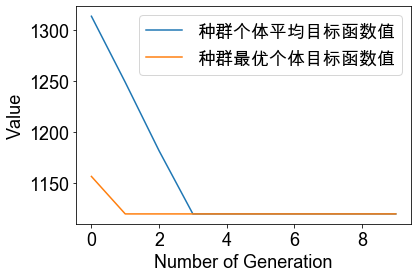

种群信息导出完毕。
用时：2012.308853 秒
评价次数：50 次
最优的目标函数值为：1119.721233844757
最优的控制变量值为：
0.5
0.5
{'mae': 0.4528178, 'mse': 0.35159886, 'rmse': 0.5929577209492368, 'evs': 0.8294727206230164, 'r2': 0.8293233253526728, 'mmax': 1.7410696, 'mmin': 0.02195704}
       X     y        PX        Py
0   0.21  3.47  0.597182  3.453387
1   1.13  1.96 -0.761869  0.369730
2   3.38  2.58  4.447841  2.760071
3   4.07  2.72  4.439410  2.712991
4   1.58  2.47  0.593868  3.452060
5   3.43  1.61  3.706064  1.642049
6   1.22  0.74  1.340622  0.464520
7   2.33  1.97  3.511646  1.483641
8   0.33  3.56  0.651546  3.474865
9   3.53  4.28  3.228709  3.871649
10  4.42  3.69  4.199565  3.481768
11  3.67  0.34  3.117561  1.212142
12  2.57  0.37  2.414230  0.839605
13  3.14  3.22  3.786991  3.732840
14  4.76  3.34  4.431844  3.106345
15  1.70  3.71  1.628835  3.771541
16  3.50  1.20  3.485194  1.463527
17  0.68  4.65  1.136723  3.642862
18  1.09  4.59  1.327056  3.697543
19  0.25  3.70  0.674858  3.483907


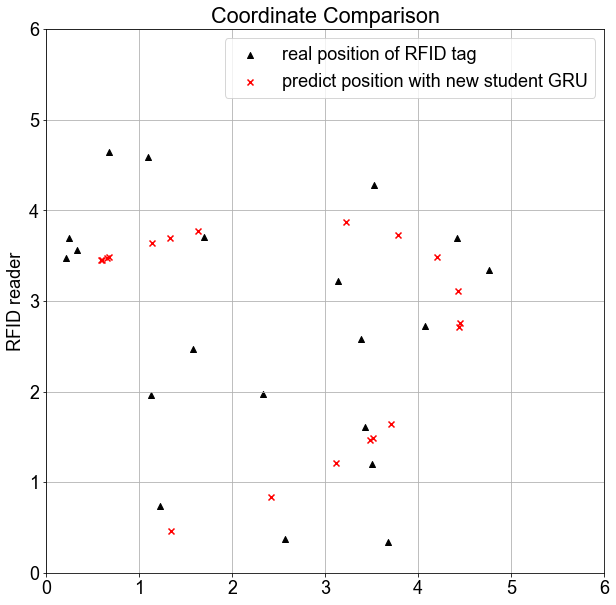

In [21]:
"""===============================实例化问题对象==========================="""

problem = MOEA(train_data_loader, test_data_loader) # 生成问题对象

"""=================================种群设置==============================="""

Encoding = 'RI'       # 编码方式
NIND = 5             # 种群规模
Field = ea.crtfld(Encoding, problem.varTypes, problem.ranges, problem.borders) # 创建区域描述器
population = ea.Population(Encoding, Field, NIND) # 实例化种群对象（此时种群还没被初始化，仅仅是完成种群对象的实例化）

"""===============================算法参数设置============================="""

myAlgorithm = ea.soea_DE_rand_1_bin_templet(problem, population) # 实例化一个算法模板对象
myAlgorithm.MAXGEN = 10 # 最大进化代数
myAlgorithm.trappedValue = 1e-6 # “进化停滞”判断阈值
myAlgorithm.maxTrappedCount = 10 # 进化停滞计数器最大上限值，如果连续maxTrappedCount代被判定进化陷入停滞，则终止进化
myAlgorithm.logTras = 1  # 设置每隔多少代记录日志，若设置成0则表示不记录日志
myAlgorithm.verbose = True  # 设置是否打印输出日志信息
myAlgorithm.drawing = 1  # 设置绘图方式（0：不绘图；1：绘制结果图；2：绘制目标空间过程动画；3：绘制决策空间过程动画）

"""===========================调用算法模板进行种群进化======================="""

[BestIndi, population] = myAlgorithm.run()  # 执行算法模板，得到最优个体以及最后一代种群
BestIndi.save()  # 把最优个体的信息保存到文件中

"""==================================输出结果============================="""

print('用时：%f 秒' % myAlgorithm.passTime)
print('评价次数：%d 次' % myAlgorithm.evalsNum)
if BestIndi.sizes != 0:
    print('最优的目标函数值为：%s' % BestIndi.ObjV[0][0])
    print('最优的控制变量值为：')
    for i in range(BestIndi.Phen.shape[1]):
        print(BestIndi.Phen[0, i])
else:
    print('没找到可行解。')

"""=================================检验结果==============================="""

problem.test(beta= float(BestIndi.Phen[0][0]), m= float(BestIndi.Phen[0][1]))
